In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## Get the Data

In [ ]:
file_path = 'housing.csv'
housing=pd.read_csv(file_path)

### Take a Quick Look at the Data Structure

In [ ]:
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [ ]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


Treat missing data in total_bedrooms columns?

In [ ]:
housing.isnull().sum()

,0
longitude,0
latitude,0
housing_median_age,0
total_rooms,0
total_bedrooms,207
population,0
households,0
median_income,0
median_house_value,0
ocean_proximity,0


In [ ]:
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


array([[<Axes: title={'center': 'longitude'}>,
        <Axes: title={'center': 'latitude'}>,
        <Axes: title={'center': 'housing_median_age'}>],
       [<Axes: title={'center': 'total_rooms'}>,
        <Axes: title={'center': 'total_bedrooms'}>,
        <Axes: title={'center': 'population'}>],
       [<Axes: title={'center': 'households'}>,
        <Axes: title={'center': 'median_income'}>,
        <Axes: title={'center': 'median_house_value'}>]], dtype=object)

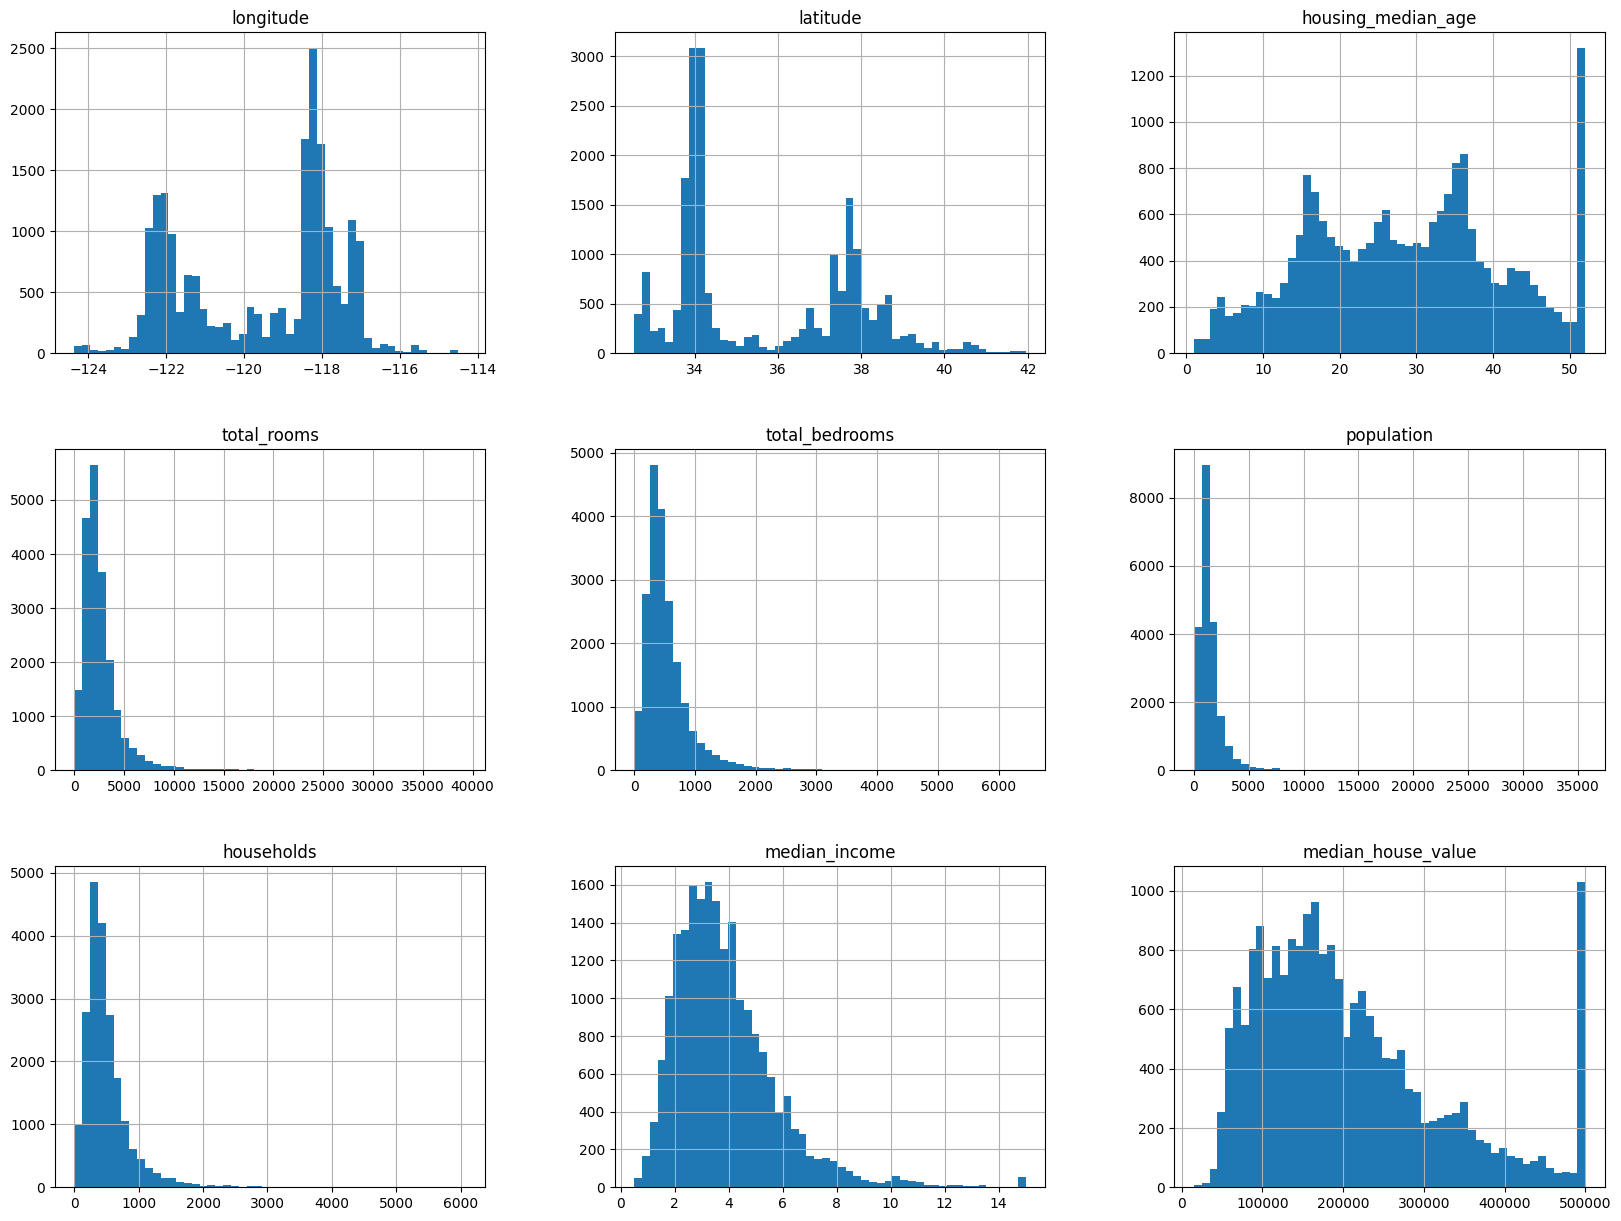

In [ ]:
housing.hist(bins=50, figsize=(20,15))

* median_income is scale down to 15-0, 3 represents roughly 30k
* median_house_income goes up to 500k, so the model will not be able to predict prices above 500k
* most of the histograms are skewed right, this make hard for the model to detect pattern, later on we are going to tranform them in bell-shaped distribution

### Create a Test Set

Whenever performing a data split, you must ensure that it will always generate the same division with the same data, so that the model is not trained with different data and has seen all the data.

In [ ]:
#funções geradas para dividir os dados em treino e teste de maneira deterministica e repetivel
from zlib import crc32
def is_id_in_test_set(identifier, test_ratio):
    return crc32(np.int64(identifier)) < test_ratio * 2**32

def split_data_with_id_hash(data, test_ratio, id_column):
    ids = data[id_column]
    in_test_set = ids.apply(lambda id_: is_id_in_test_set(id_, test_ratio))
    return data.loc[~in_test_set], data.loc[in_test_set]


In [ ]:
housing_with_id = housing.reset_index()   # adds an `index` column
train_set, test_set=split_data_with_id_hash(housing_with_id, 0.2, "index")

Sklearn provides various functions to split data, including train_test_split() and other cross-validation splitters like KFold, StratifiedKFold, and TimeSeriesSplit.

In [ ]:
from sklearn.model_selection import train_test_split
train_set, test_set= train_test_split(housing, test_size=0.2, random_state=42)

Until this moment we are spliting the data in a random way, wich would be 'fine' if you have a large dataset, but if you dont, you are risking introducing a significant SAMPLING BIAS

We have been told that the median_income is very important to our model , so we are going to categorized in 5 bins

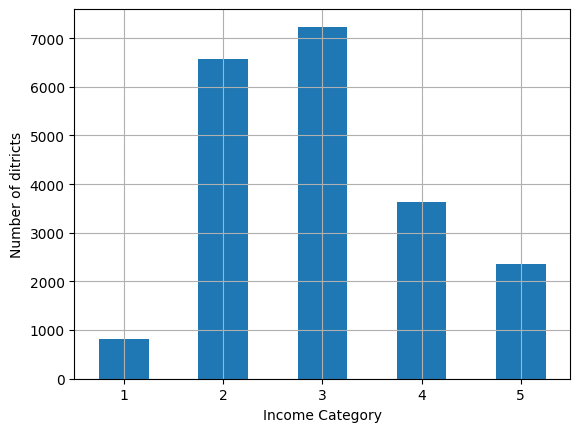

In [ ]:
housing["income_cat"]=pd.cut(housing["median_income"], bins=[0., 1.5, 3.0, 4.5, 6., np.inf], labels=[1, 2, 3, 4, 5])
housing["income_cat"].value_counts().sort_index().plot.bar(rot=0,grid=True)
plt.xlabel("Income Category")
plt.ylabel("Number of ditricts")
plt.show()

The stratify parameter allows it to separate the training and test data with the same proportion of each classification from the "income_cat" column.

In [ ]:
strat_train_set, strat_test_set = train_test_split(housing, test_size=0.2, random_state=42, stratify=housing["income_cat"])

Proporção dos dados de da coluna criada de income category para os dados de treino e teste são a mesma

In [ ]:
strat_test_set["income_cat"].value_counts()/len(strat_test_set)

,count
income_cat,
3,0.350533
2,0.318798
4,0.176357
5,0.114341
1,0.039971


In [ ]:
strat_train_set["income_cat"].value_counts()/len(strat_train_set)

,count
income_cat,
3,0.350594
2,0.318859
4,0.176296
5,0.114462
1,0.039789


In [ ]:
for set_ in (strat_train_set, strat_test_set):
    set_.drop("income_cat", axis=1, inplace=True)

## Explore and visualize the Data to Gain Insights

Lets explore the training data set

### Visualazing the geographic data

In [ ]:
#making an copy so we can play with the data without harming the original
housing = strat_train_set.copy()

<Axes: xlabel='longitude', ylabel='latitude'>

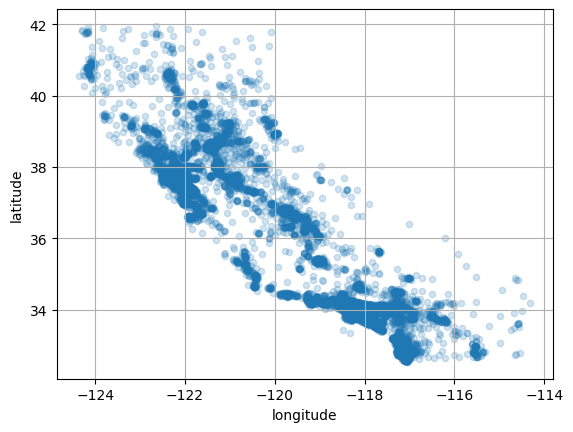

In [ ]:
#alpha controls the densisty
housing.plot(kind="scatter", x="longitude", y="latitude",grid=True, alpha=0.2)

<Axes: xlabel='longitude', ylabel='latitude'>

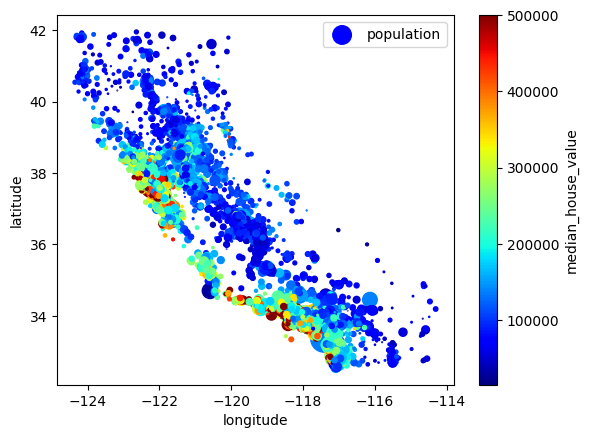

In [ ]:
housing.plot(kind="scatter",x="longitude",y="latitude",s=housing["population"]/100,label="population",c="median_house_value",cmap="jet",colorbar=True,)

### Look for Correlations

In [ ]:
corr_matrix=housing.corr(numeric_only=True)

In [ ]:
corr_matrix["median_house_value"].sort_values(ascending=False)

,median_house_value
median_house_value,1.000000
median_income,0.687151
total_rooms,0.135140
housing_median_age,0.114146
households,0.064590
total_bedrooms,0.047781
population,-0.026882
longitude,-0.047466
latitude,-0.142673


The function scatter matrix plots every numerical attribute against every other numerical attribute, plus a histogram of each numerical attribute's values on the main diagonal

array([[<Axes: xlabel='median_house_value', ylabel='median_house_value'>,
        <Axes: xlabel='median_income', ylabel='median_house_value'>,
        <Axes: xlabel='total_rooms', ylabel='median_house_value'>,
        <Axes: xlabel='housing_median_age', ylabel='median_house_value'>],
       [<Axes: xlabel='median_house_value', ylabel='median_income'>,
        <Axes: xlabel='median_income', ylabel='median_income'>,
        <Axes: xlabel='total_rooms', ylabel='median_income'>,
        <Axes: xlabel='housing_median_age', ylabel='median_income'>],
       [<Axes: xlabel='median_house_value', ylabel='total_rooms'>,
        <Axes: xlabel='median_income', ylabel='total_rooms'>,
        <Axes: xlabel='total_rooms', ylabel='total_rooms'>,
        <Axes: xlabel='housing_median_age', ylabel='total_rooms'>],
       [<Axes: xlabel='median_house_value', ylabel='housing_median_age'>,
        <Axes: xlabel='median_income', ylabel='housing_median_age'>,
        <Axes: xlabel='total_rooms', ylabel='housi

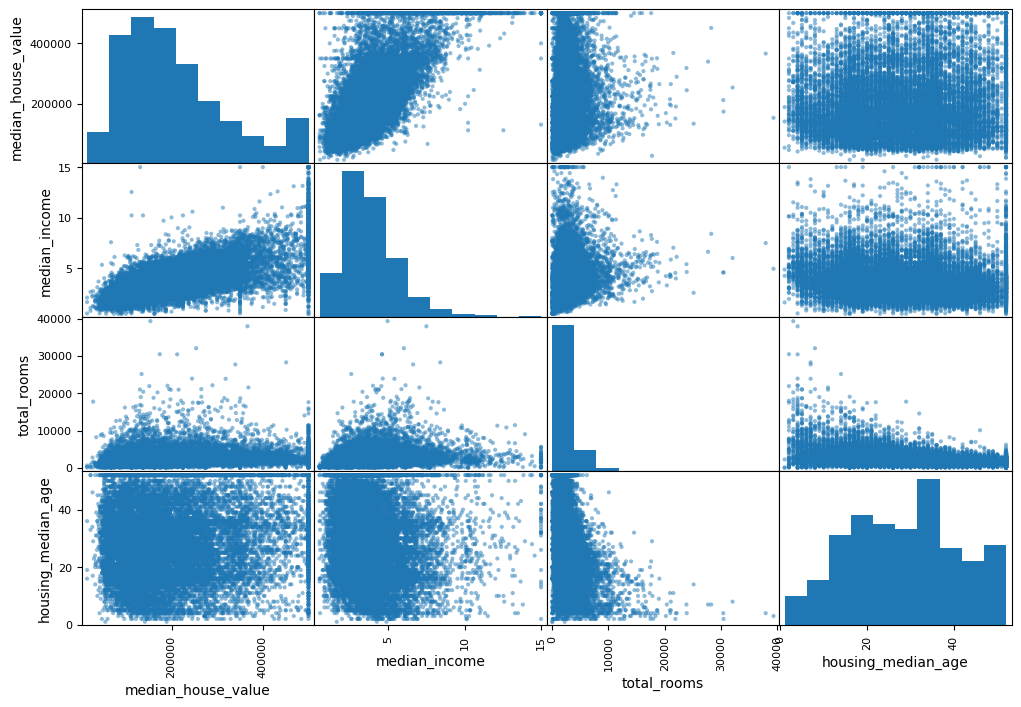

In [ ]:
from pandas.plotting import scatter_matrix
attributes=["median_house_value","median_income","total_rooms","housing_median_age"]
scatter_matrix(housing[attributes],figsize=(12,8))

The correlation is indeed quite strong, the points are not too dispersed. We have horizontal line at 500k,450k,350k and perhaps more between 280k and below that

<Axes: xlabel='median_income', ylabel='median_house_value'>

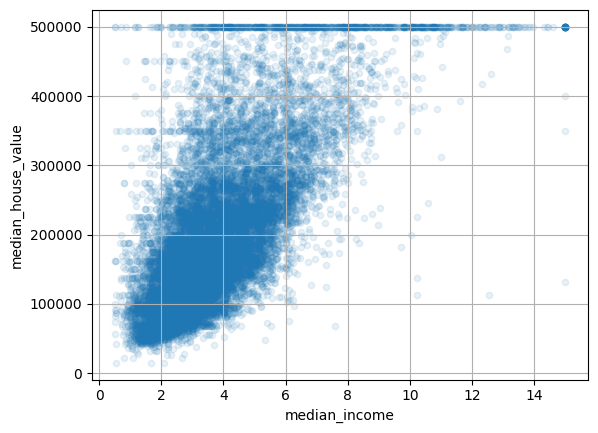

In [ ]:
housing.plot(kind="scatter",x="median_income",y="median_house_value",alpha=0.1,grid=True)

### Experiment with Attribute Combinatios

In [ ]:
housing["rooms_per_house"] = housing["total_rooms"] / housing["households"]
housing["bedrooms_ratio"] = housing["total_bedrooms"] / housing["total_rooms"]
housing["people_per_house"] = housing["population"] / housing["households"]

bedrooms_ratio are more correlated than total_rooms

In [ ]:
corr_matrix = housing.corr(numeric_only=True)
corr_matrix["median_house_value"].sort_values(ascending=False)

,median_house_value
median_house_value,1.000000
median_income,0.687151
rooms_per_house,0.146255
total_rooms,0.135140
housing_median_age,0.114146
households,0.064590
total_bedrooms,0.047781
people_per_house,-0.021991
population,-0.026882
longitude,-0.047466


## Prepare the Data for Machine Learning Algorithm

In [ ]:
housing = strat_train_set.drop("median_house_value", axis=1)
housing_labels = strat_train_set["median_house_value"].copy()

#### Handle missing values in 3 ways:

* 1-) Delete the feature
* 2-) Delete the rows
* 3-) Impute the missing values

The SimpleImputer from scikit-learn is a class used to fill missing values in a dataset. It offers several imputation strategies, such as replacing missing values with the mean, median, mode, or a constant value

In [ ]:
from sklearn.impute import SimpleImputer

In [ ]:
imputer = SimpleImputer(strategy="median")

In [ ]:
housing_num = housing.select_dtypes(include=[np.number])
X=imputer.fit_transform(housing_num)

imputer.statistics_  returns the statistics (mean, median, mode, or constant) learned during fitting for each feature

In [ ]:
imputer.statistics_

array([-118.51   ,   34.26   ,   29.     , 2119.     ,  433.     ,
       1164.     ,  408.     ,    3.54155])

imputer.strategy returns which imputation method is being used

In [ ]:
imputer.strategy

'median'

In [ ]:
housing_num.median().values

array([-118.51   ,   34.26   ,   29.     , 2119.     ,  433.     ,
       1164.     ,  408.     ,    3.54155])

Scikit-learn always returns NumPy arrays or scipy Sparse matrices! This is a key feature of scikit-learn. Even when you provide data in other formats (like pandas DataFrames), the output will always be NumPy arrays (for dense data) or scipy Sparse matrices (for sparse data). This helps maintain consistency and efficiency in operations

In [ ]:
housing_tr=pd.DataFrame(X,columns=housing_num.columns,index=housing_num.index)

### Handling Outliers

For handling outliers in your dataset, several effective methods are available, with the Z-Score method and IsolationForest from scikit-learn being among the most popular. The Z-Score method identifies outliers by measuring how many standard deviations a data point is from the mean (typically ±3), making it ideal for normally distributed data. IsolationForest, on the other hand, is particularly effective for high-dimensional datasets and works by isolating outliers through random partitioning. Other valuable approaches include the Interquartile Range (IQR) method, which is less sensitive to extreme values, and the Local Outlier Factor (LOF), which detects outliers based on local density deviations.

In [ ]:
from sklearn.ensemble import IsolationForest

isolation_forest = IsolationForest(random_state=42)
outlier_pred = isolation_forest.fit_predict(X)

In [ ]:
#housing = housing.iloc[outlier_pred == 1]
#housing_labels = housing_labels.iloc[outlier_pred == 1]

### Handling Text and Categorical Attributes

In [ ]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
Index: 16512 entries, 12655 to 19773
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           16512 non-null  float64
 1   latitude            16512 non-null  float64
 2   housing_median_age  16512 non-null  float64
 3   total_rooms         16512 non-null  float64
 4   total_bedrooms      16354 non-null  float64
 5   population          16512 non-null  float64
 6   households          16512 non-null  float64
 7   median_income       16512 non-null  float64
 8   ocean_proximity     16512 non-null  object 
dtypes: float64(8), object(1)
memory usage: 1.3+ MB


In [ ]:
housing_cat = housing[["ocean_proximity"]]
housing_cat

,ocean_proximity
12655,INLAND
15502,NEAR OCEAN
2908,INLAND
14053,NEAR OCEAN
20496,<1H OCEAN
...,...
15174,<1H OCEAN
12661,INLAND
19263,<1H OCEAN
19140,<1H OCEAN


We can use the OrdinalEncoder to transform categorical data into numerical, but it will use an order that may lead the ML to think that some categories are more similar to others (bad, average, good, excellent). That's when we use OneHotEncoder

In [ ]:
from sklearn.preprocessing import OneHotEncoder

In [ ]:
cat_encoder = OneHotEncoder()
housing_cat_1hot = cat_encoder.fit_transform(housing_cat)

OneHotEncoder returns a Sparse Matrix, which is a very efficient representation of matrices since it only stores the non-zero values and their positions

In [ ]:
housing_cat_1hot.toarray()

array([[0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       ...,
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])

In [ ]:
print(cat_encoder.categories_)
print(cat_encoder.feature_names_in_)
print(cat_encoder.get_feature_names_out())

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
      dtype=object)]
['ocean_proximity']
['ocean_proximity_<1H OCEAN' 'ocean_proximity_INLAND'
 'ocean_proximity_ISLAND' 'ocean_proximity_NEAR BAY'
 'ocean_proximity_NEAR OCEAN']


### Feature Scaling and Transformation

Most Machine Learning models perform poorly when features are on different scales, with the exception of tree-based models (like Decision Trees, Random Forests, and Gradient Boosting)


Min-max scaling is the simplest scaling method and consists of rescaling the range of features to [0, 1] or [-1, 1]. The selection of the target range depends on the nature of the data. The scaling is performed by subtracting the minimum value and dividing by the range (difference between maximum and minimum values). However, this method is highly sensitive to outliers

In [ ]:
from sklearn.preprocessing import MinMaxScaler
min_max_scaler = MinMaxScaler(feature_range=(-1,1))
housing_num_min_max_sclaed=min_max_scaler.fit_transform(housing_num)

Standardization subtracts the mean and divides by the standard deviation. Unlike Min-Max scaling, standardization does not bound values to a specific range, which may be a problem for some algorithms (e.g., neural networks often expect input values ranging from 0 to 1). However, standardization is much less affected by outliers. For example, suppose a district had a median income equal to 100 (by mistake). Min-Max scaling would then crush all the other values from 0-15 down to 0-0.15, whereas standardization would not be much affected. Scikit-Learn provides a transformer called StandardScaler for standardization

In [ ]:
from sklearn.preprocessing import StandardScaler
# set hyperparameter with_mean when to False when using it in sparse matrix
std_scaler = StandardScaler()
housing_num_std_scaled = std_scaler.fit_transform(housing_num)

The data distribution is very important for non-tree-based models like linear regression, so it's important to transform the features to have a Gaussian distribution

If a feature has a **power law distribution (heavy-tail)** , then replacing the feature with its logarithm may help. Another approach is to bucketize the feature, where you divide the distribution into roughly equal-sized buckets, and replace each feature value with its index (you can divide by the total number of buckets to normalize the values from 0 to 1)



**Multimodal distributions**  (distributions with two or more clear peaks) can be transformed into a form suitable for machine learning models using bucketizing and One-Hot Encoding. The binning captures the structure of the multimodal distribution, and the One-Hot Encoding avoids imposing an ordinal relationship between the bins. Another approach is to identify peaks in the multimodal distribution, create new features using Radial Basis Function (RBF) exp(-γ(x - center)²) for each peak, and use these features as inputs for the machine learning model. This captures the structure of the distribution and avoids assuming normality



In [ ]:
from sklearn.metrics.pairwise import rbf_kernel
age_similarity_35=rbf_kernel(housing[['housing_median_age']], [[35]],gamma=0.1)



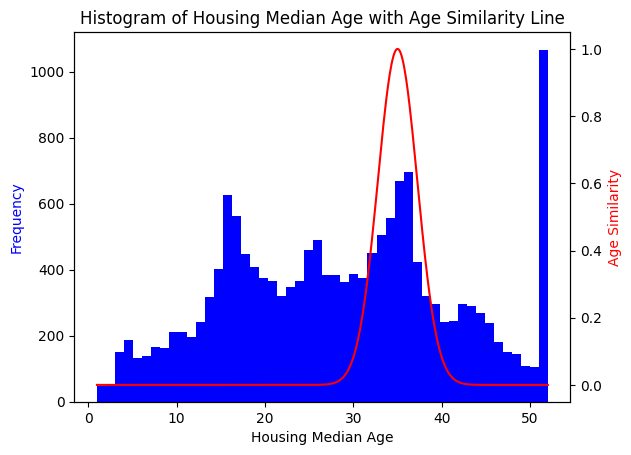

In [ ]:
ages = np.linspace(housing["housing_median_age"].min(),
                   housing["housing_median_age"].max(),
                   500).reshape(-1, 1)

age_similarity_35=rbf_kernel(ages, [[35]],gamma=0.1)
fig, ax1 = plt.subplots()

# Plot histogram
ax1.hist(housing["housing_median_age"], bins=50, color='blue')
ax1.set_xlabel('Housing Median Age')
ax1.set_ylabel('Frequency', color='blue')

# Create a second y-axis to plot the age similarity line
ax2 = ax1.twinx()
ax2.plot(ages, age_similarity_35, color='red')
ax2.set_ylabel('Age Similarity', color='red')

plt.title('Histogram of Housing Median Age with Age Similarity Line')
plt.show()

TransformedTargetRegressor() is very useful when building models that need to use transformers, because it can easily fit the transformed data and predict the untransformed data. This is particularly helpful in cases where you have a target variable with a very long distribution tail that looks like an exponential function. In such cases, when you transform the target to logarithmic scale, the predictions need to be transformed back to make sense in the original scale

In [ ]:
from sklearn.compose import TransformedTargetRegressor
from sklearn.linear_model import LinearRegression
model=TransformedTargetRegressor(LinearRegression(),transformer=StandardScaler())
model.fit(X,housing_labels)
fake_new_data=X[0:10,:]
model.predict(fake_new_data)

array([ 95459.68317105, 293716.8121371 , 176469.51698334, 177682.46559536,
       243132.13655331, 200057.03241449, 374073.383633  , 262845.39000511,
       147567.82922971,   3165.71665949])

### Custom Transformers

They are very usefull to custom transformations, cleanup operatins, combining specif attibutes ad pipelines

FunctionTransformer is a scikit-learn utility that converts Python functions into transformer objects, allowing custom transformations to be integrated into scikit-learn pipelines. It's a simple way to create custom transformers when standard preprocessing tools don't meet your specific needs, enabling you to apply any custom function to your data while maintaining sklearn's transformer interface

Normalizing using log

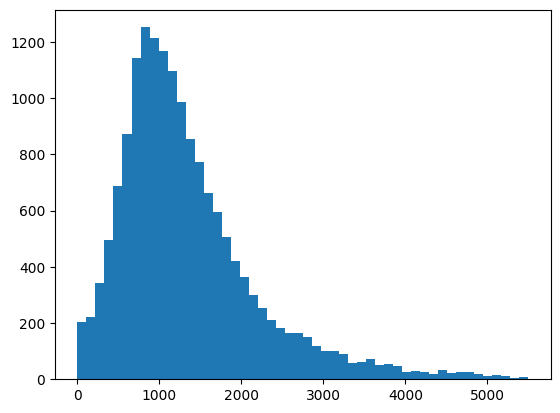

In [ ]:
plt.hist(housing[["population"]],bins=50,range=(0,5500))
plt.show()

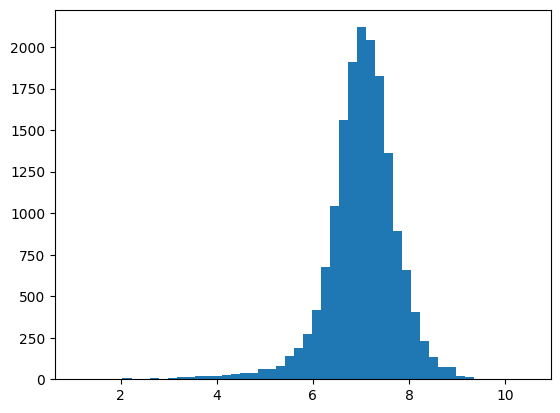

In [ ]:
from sklearn.preprocessing import FunctionTransformer

log_transformer = FunctionTransformer(np.log, inverse_func=np.exp)
log_pop = log_transformer.transform(housing[["population"]])
original_pop = log_transformer.inverse_transform(log_pop)

plt.hist(log_pop,bins=50)
plt.show()

Using RBF function

In [ ]:
rbf_transformer = FunctionTransformer(rbf_kernel,
                                      kw_args=dict(Y=[[35.]], gamma=0.1))
age_simil_35 = rbf_transformer.transform(housing[["housing_median_age"]])

To create a custom transformer class in scikit-learn, you need to implement three essential methods: fit(), transform(), and fit_transform(). However, by inheriting from TransformerMixin and BaseEstimator, you can simplify this process as TransformerMixin automatically provides the fit_transform() method, while BaseEstimator provides get_params() and set_params() methods for parameter handling. This inheritance ensures your custom transformer will work seamlessly with scikit-learn's pipeline and cross-validation tools, requiring you to implement only fit() and transform() methods.

In [ ]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils.validation import check_array, check_is_fitted

class StandardScalerClone(BaseEstimator, TransformerMixin):
  def __init__(self, with_mean=True):  # no *args or **kwargs!
      self.with_mean = with_mean

  def fit(self, X, y=None):  # y is required even though we don't use it
      # Store feature names if X is a DataFrame
      if isinstance(X, pd.DataFrame):
          self.feature_names_in_ = X.columns.tolist()
          X = X.values

      X = check_array(X)  # checks that X is an array with finite float values
      self.mean_ = X.mean(axis=0)
      self.scale_ = X.std(axis=0)
      self.n_features_in_ = X.shape[1]  # every estimator stores this in fit()
      return self  # always return self!

  def transform(self, X):
      check_is_fitted(self)  # looks for learned attributes (with trailing _)
      if isinstance(X, pd.DataFrame):
          X = X.values
      X = check_array(X)
      assert self.n_features_in_ == X.shape[1]
      if self.with_mean:
          X = X - self.mean_
      return X / self.scale_

  def inverse_transform(self, X):
      check_is_fitted(self)
      X = check_array(X)
      X = X * self.scale_
      if self.with_mean:
          X = X + self.mean_
      return X

  def get_feature_names_out(self, feature_names_in=None):
      """Get output feature names."""
      check_is_fitted(self)
      if feature_names_in is None:
          if hasattr(self, 'feature_names_in_'):
              feature_names_in = self.feature_names_in_
          else:
              feature_names_in = [f"f{i}" for i in range(self.n_features_in_)]
      return feature_names_in

The ClusterSimilarity class is a custom transformer that combines K-means clustering with RBF (Radial Basis Function) transformation to measure similarities between data points and cluster centers. It works by first using K-means to identify cluster centers in the data during the fit phase, then in the transform phase, it calculates similarity scores between each input point and these cluster centers using the RBF kernel function.

In [ ]:
from sklearn.cluster import KMeans

class ClusterSimilarity(BaseEstimator, TransformerMixin):
    def __init__(self, n_clusters=10, gamma=1.0, random_state=None):
        self.n_clusters = n_clusters
        self.gamma = gamma
        self.random_state = random_state

    def fit(self, X, y=None, sample_weight=None):
        self.kmeans_ = KMeans(self.n_clusters, n_init=10,
                              random_state=self.random_state)
        self.kmeans_.fit(X, sample_weight=sample_weight)
        return self  # always return self!

    def transform(self, X):
        return rbf_kernel(X, self.kmeans_.cluster_centers_, gamma=self.gamma)

    def get_feature_names_out(self, names=None):
        return [f"Cluster {i} similarity" for i in range(self.n_clusters)]


In this code implementation, the clustering is not purely based on demographic density. Instead, by using sample_weight=housing_labels, the KMeans algorithm weights the clustering process using house prices as weights. This means that areas with higher house prices will have more influence in determining the cluster centers, effectively "pulling" the clusters towards regions with higher property values.
In this code implementation, the clustering is not purely based on demographic density. Instead, by using sample_weight=housing_labels, the KMeans algorithm weights the clustering process using house prices as weights. This means that areas with higher house prices will have more influence in determining the cluster centers, effectively "pulling" the clusters towards regions with higher property values.

In [ ]:
cluster_simil = ClusterSimilarity(n_clusters=10, gamma=1., random_state=42)
similarities = cluster_simil.fit_transform(housing[["latitude", "longitude"]],
                                           sample_weight=housing_labels)

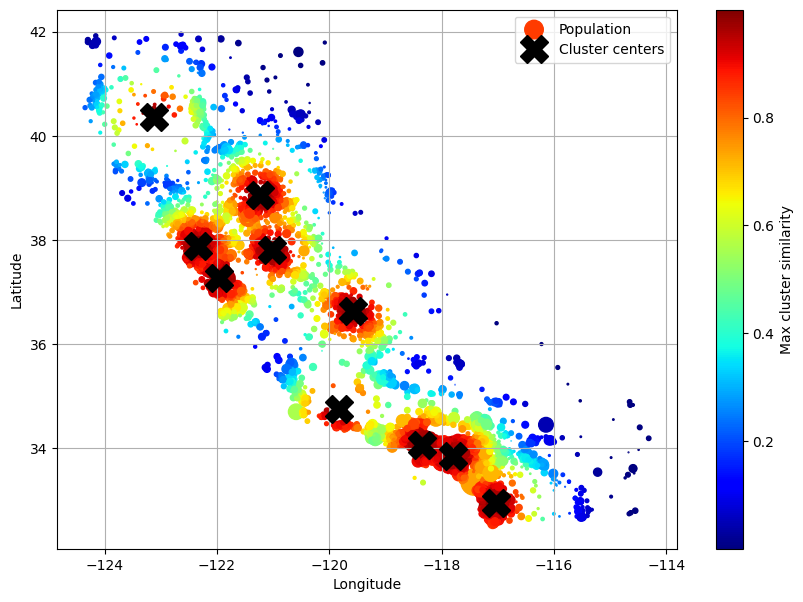

In [ ]:
housing_renamed = housing.rename(columns={
    "latitude": "Latitude", "longitude": "Longitude",
    "population": "Population",
    "median_house_value": "Median house value (ᴜsᴅ)"})
housing_renamed["Max cluster similarity"] = similarities.max(axis=1)

housing_renamed.plot(kind="scatter", x="Longitude", y="Latitude", grid=True,
                     s=housing_renamed["Population"] / 100, label="Population",
                     c="Max cluster similarity",
                     cmap="jet", colorbar=True,
                     legend=True, sharex=False, figsize=(10, 7))
plt.plot(cluster_simil.kmeans_.cluster_centers_[:, 1],
         cluster_simil.kmeans_.cluster_centers_[:, 0],
         linestyle="", color="black", marker="X", markersize=20,
         label="Cluster centers")
plt.legend(loc="upper right")
plt.show()

### Transformation Pipelines

The sklearn Pipeline class enables sequential machine learning workflows by chaining preprocessing steps and a final estimator. Its main parameter, 'steps', accepts a list of (name, estimator) tuples defining the processing sequence. Parameters are accessed using 'step_name__parameter_name' format. Pipeline prevents data leakage between training and test sets while making complex workflows more maintainable through a clean, unified interface for preprocessing and modeling

The difference between Pipeline() and make_pipeline() is that in the second one you don't specify the names of the transformers in the pipeline

In [ ]:
from sklearn.pipeline import Pipeline, make_pipeline

num_pipeline = Pipeline([
    ("impute", SimpleImputer(strategy="median")),
    ("standardize", StandardScaler()),
])
num_pipeline = make_pipeline(SimpleImputer(strategy="median"), StandardScaler())
num_pipeline

Pipeline(steps=[('simpleimputer', SimpleImputer(strategy='median')),
                ('standardscaler', StandardScaler())])

In [ ]:
print(num_pipeline.steps)
print(num_pipeline.named_steps["simpleimputer"])
print(num_pipeline.set_params(simpleimputer__strategy="median"))

[('simpleimputer', SimpleImputer(strategy='median')), ('standardscaler', StandardScaler())]
SimpleImputer(strategy='median')
Pipeline(steps=[('simpleimputer', SimpleImputer(strategy='median')),
                ('standardscaler', StandardScaler())])


In [ ]:
housing_num_prepared = num_pipeline.fit_transform(housing_num)
housing_num_prepared[:2].round(2)
df_housing_num_prepared = pd.DataFrame(
    housing_num_prepared, columns=num_pipeline.get_feature_names_out(),
    index=housing_num.index)
df_housing_num_prepared

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
12655,-0.941350,1.347438,0.027564,0.584777,0.640371,0.732602,0.556286,-0.893647
15502,1.171782,-1.192440,-1.722018,1.261467,0.781561,0.533612,0.721318,1.292168
2908,0.267581,-0.125972,1.220460,-0.469773,-0.545138,-0.674675,-0.524407,-0.525434
14053,1.221738,-1.351474,-0.370069,-0.348652,-0.036367,-0.467617,-0.037297,-0.865929
20496,0.437431,-0.635818,-0.131489,0.427179,0.272790,0.374060,0.220898,0.325752
...,...,...,...,...,...,...,...,...
15174,1.251711,-1.220505,-1.165333,1.890456,1.696862,0.543471,1.341519,0.637374
12661,-0.921368,1.342761,-1.085806,2.468471,2.161816,3.002174,2.451492,-0.557509
19263,-1.570794,1.310018,1.538566,-0.895802,-0.895679,-0.862013,-0.865118,-0.365475
19140,-1.560803,1.249211,-1.165333,0.249005,0.112126,-0.189747,0.010616,0.168261


The ColumnTransformer is a key scikit-learn tool that applies different transformations to specific dataset columns simultaneously. In the example, it processes numerical and categorical attributes through separate pipelines. The "remainder" parameter can be set to 'drop' (removes unspecified columns) or 'passthrough' (keeps unspecified columns unchanged)

In [ ]:
from sklearn.compose import ColumnTransformer

num_attribs = ["longitude", "latitude", "housing_median_age", "total_rooms",
               "total_bedrooms", "population", "households", "median_income"]
cat_attribs = ["ocean_proximity"]

cat_pipeline = make_pipeline(
    SimpleImputer(strategy="most_frequent"),
    OneHotEncoder(handle_unknown="ignore"))

preprocessing = ColumnTransformer([
    ("num", num_pipeline, num_attribs),
    ("cat", cat_pipeline, cat_attribs),
])


The make_column_transformer and make_column_selector are convenient wrapper functions similar to make_pipeline, offering a more concise syntax for data preprocessing. While make_column_transformer simplifies the ColumnTransformer creation by eliminating the need for explicit tuples, make_column_selector helps in automatically selecting columns based on their data types (like dtype_selector) or patterns (like pattern_selector).

In [ ]:
from sklearn.compose import make_column_selector, make_column_transformer

preprocessing = make_column_transformer(
    (num_pipeline, make_column_selector(dtype_include=np.number)),
    (cat_pipeline, make_column_selector(dtype_include=object)),
)

In [ ]:
housing_prepared = preprocessing.fit_transform(housing)
housing_prepared_fr = pd.DataFrame(
    housing_prepared,
    columns=preprocessing.get_feature_names_out(),
    index=housing.index)
housing_prepared_fr.head(2)

,pipeline-1__longitude,pipeline-1__latitude,pipeline-1__housing_median_age,pipeline-1__total_rooms,pipeline-1__total_bedrooms,pipeline-1__population,pipeline-1__households,pipeline-1__median_income,pipeline-2__ocean_proximity_<1H OCEAN,pipeline-2__ocean_proximity_INLAND,pipeline-2__ocean_proximity_ISLAND,pipeline-2__ocean_proximity_NEAR BAY,pipeline-2__ocean_proximity_NEAR OCEAN
12655,-0.941350,1.347438,0.027564,0.584777,0.640371,0.732602,0.556286,-0.893647,0.0,1.0,0.0,0.0,0.0
15502,1.171782,-1.192440,-1.722018,1.261467,0.781561,0.533612,0.721318,1.292168,0.0,0.0,0.0,0.0,1.0


In [ ]:
# Defines a function to calculate ratio between first and second column of input array
def column_ratio(X):
  return X[:, [0]] / X[:, [1]]

# Defines a function to name the output feature of the ratio transformation
def ratio_name(function_transformer, feature_names_in):
  return ["ratio"]  # feature names out

# Creates a pipeline that imputes missing values, calculates ratios, and standardizes
def ratio_pipeline():
  return make_pipeline(
    SimpleImputer(strategy="median"),  # Fill missing values with median
    FunctionTransformer(column_ratio, feature_names_out=ratio_name),  # Apply ratio transformation
    StandardScaler())  # Standardize the result

# Creates a pipeline that imputes missing values, applies log transformation, and standardizes
log_pipeline = make_pipeline(
SimpleImputer(strategy="median"),  # Fill missing values with median
FunctionTransformer(np.log, feature_names_out="one-to-one"),  # Apply log transformation
StandardScaler())  # Standardize the result

# Creates a cluster similarity transformer with 10 clusters
cluster_simil = ClusterSimilarity(n_clusters=10, gamma=1., random_state=42)

# Creates a default pipeline for numerical features
default_num_pipeline = make_pipeline(SimpleImputer(strategy="median"),
                                 StandardScaler())

# Creates a ColumnTransformer that applies different transformations to different columns
preprocessing = ColumnTransformer([
    ("bedrooms", ratio_pipeline(), ["total_bedrooms", "total_rooms"]),  # Ratio of bedrooms to rooms
    ("rooms_per_house", ratio_pipeline(), ["total_rooms", "households"]),  # Ratio of rooms to households
    ("people_per_house", ratio_pipeline(), ["population", "households"]),  # Ratio of population to households
    ("log", log_pipeline, ["total_bedrooms", "total_rooms", "population",
                           "households", "median_income"]),  # Log transform for these features
    ("geo", cluster_simil, ["latitude", "longitude"]),  # Cluster similarity for geographical features
    ("cat", cat_pipeline, make_column_selector(dtype_include=object)),  # Process categorical features
],
remainder=default_num_pipeline)  # Apply default pipeline to remaining numerical features

In [ ]:
housing_prepared = preprocessing.fit_transform(housing)
print(f'Shape: {housing_prepared.shape}')
print(f'Columns: {preprocessing.get_feature_names_out()}')

Shape: (16512, 24)
Columns: ['bedrooms__ratio' 'rooms_per_house__ratio' 'people_per_house__ratio'
 'log__total_bedrooms' 'log__total_rooms' 'log__population'
 'log__households' 'log__median_income' 'geo__Cluster 0 similarity'
 'geo__Cluster 1 similarity' 'geo__Cluster 2 similarity'
 'geo__Cluster 3 similarity' 'geo__Cluster 4 similarity'
 'geo__Cluster 5 similarity' 'geo__Cluster 6 similarity'
 'geo__Cluster 7 similarity' 'geo__Cluster 8 similarity'
 'geo__Cluster 9 similarity' 'cat__ocean_proximity_<1H OCEAN'
 'cat__ocean_proximity_INLAND' 'cat__ocean_proximity_ISLAND'
 'cat__ocean_proximity_NEAR BAY' 'cat__ocean_proximity_NEAR OCEAN'
 'remainder__housing_median_age']


## Select and Train Model

Using Linear Model causing an underfitting

In [ ]:
from sklearn.linear_model import LinearRegression

lin_reg = make_pipeline(preprocessing, LinearRegression())
lin_reg.fit(housing, housing_labels)


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder=Pipeline(steps=[('simpleimputer',
                                                              SimpleImputer(strategy='median')),
                                                             ('standardscaler',
                                                              StandardScaler())]),
                                   transformers=[('bedrooms',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('functiontransformer',
                                                                   FunctionTransformer(feature_names_out=<function ratio_name at 0x7a5...
                                                   'median_income']),
                                                 ('geo',
                                                  ClusterSimilarity(random_state=42),
                                                  ['latitude', 'longitude']),
                                                 ('cat',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7a51ac4b13d0>)])),
                ('linearregression', LinearRegression())])

In [ ]:
from sklearn.metrics import root_mean_squared_error

housing_predictions = lin_reg.predict(housing)
lin_rmse = root_mean_squared_error(housing_labels, housing_predictions)
lin_rmse

69239.95619019211

Using DecisionTree causing an overfitting

In [ ]:
from sklearn.tree import DecisionTreeRegressor

tree_reg = make_pipeline(preprocessing, DecisionTreeRegressor(random_state=42))
tree_reg.fit(housing, housing_labels)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder=Pipeline(steps=[('simpleimputer',
                                                              SimpleImputer(strategy='median')),
                                                             ('standardscaler',
                                                              StandardScaler())]),
                                   transformers=[('bedrooms',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('functiontransformer',
                                                                   FunctionTransformer(feature_names_out=<function ratio_name at 0x7a5...
                                                  ClusterSimilarity(random_state=42),
                                                  ['latitude', 'longitude']),
                                                 ('cat',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7a51ac4b13d0>)])),
                ('decisiontreeregressor',
                 DecisionTreeRegressor(random_state=42))])

In [ ]:
housing_predictions = tree_reg.predict(housing)
lin_rmse = root_mean_squared_error(housing_labels, housing_predictions)
lin_rmse

0.0

Cross-validation, as demonstrated with cross_val_score, is a crucial technique for robustly evaluating machine learning model performance, surpassing a simple train/test split. By dividing the dataset into multiple "folds" (here, 10 with cv=10), the model is trained and evaluated repeatedly, each time using a different fold as the validation set and the remaining folds as the training set.

The standard deviation of the cross-validation results indicates the variability of the model's performance across different data subsets, reflecting the model's stability and generalization ability

In [ ]:
from sklearn.model_selection import cross_val_score

tree_rmses = -cross_val_score(tree_reg, housing, housing_labels, scoring="neg_root_mean_squared_error", cv=10)
#neg_root_mean_squared_error is used to tell cross_val_score that lower RMSE is better
pd.Series(tree_rmses).describe()

,0
count,10.000000
mean,67222.995977
std,3918.520742
min,58898.978399
25%,65673.581208
50%,67195.125565
75%,69494.553444
max,73180.532285


Using Random Forest

In [ ]:
from sklearn.ensemble import RandomForestRegressor

forest_reg = make_pipeline(preprocessing,RandomForestRegressor(random_state=42))
forest_reg.fit(housing, housing_labels)
housing_predictions = forest_reg.predict(housing)
forest_rmse = root_mean_squared_error(housing_labels, housing_predictions)
forest_rmse

17520.908185109398

In [ ]:
forest_rmses = -cross_val_score(forest_reg, housing, housing_labels,scoring="neg_root_mean_squared_error", cv=10)
pd.Series(forest_rmses).describe()

,0
count,10.000000
mean,47196.080803
std,2518.953159
min,43480.358064
25%,45295.803304
50%,47347.433859
75%,48761.308355
max,51158.799732


## FIne-Tune Your Model

### GridSerch

Grid Search automates hyperparameter tuning by exhaustively searching a defined grid of values, training and evaluating the model for each combination. Within pipelines, hyperparameters are accessed using the pipeline_step_name__hyperparameter_name notation. Crucially, GridSearchCV automatically refits the model with the best-performing hyperparameters found during the search, storing the fully trained model in the best_estimator_ attribute, ready for immediate use without manual adjustments

In [ ]:
from sklearn.model_selection import GridSearchCV

full_pipeline = Pipeline([
    ("preprocessing", preprocessing),
    ("random_forest", RandomForestRegressor(random_state=42)),
])
param_grid = [
    {'preprocessing__geo__n_clusters': [5, 8, 10],
     'random_forest__max_features': [4, 6, 8]},
    {'preprocessing__geo__n_clusters': [10, 15],
     'random_forest__max_features': [6, 8, 10]},
]
grid_search = GridSearchCV(full_pipeline, param_grid, cv=3,
                           scoring='neg_root_mean_squared_error')
grid_search.fit(housing, housing_labels)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('preprocessing',
                                        ColumnTransformer(remainder=Pipeline(steps=[('simpleimputer',
                                                                                     SimpleImputer(strategy='median')),
                                                                                    ('standardscaler',
                                                                                     StandardScaler())]),
                                                          transformers=[('bedrooms',
                                                                         Pipeline(steps=[('simpleimputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('functiontransformer',
                                                                                          FunctionTransformer(feature_names_out=<f...
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x7a51ac4b13d0>)])),
                                       ('random_forest',
                                        RandomForestRegressor(random_state=42))]),
             param_grid=[{'preprocessing__geo__n_clusters': [5, 8, 10],
                          'random_forest__max_features': [4, 6, 8]},
                         {'preprocessing__geo__n_clusters': [10, 15],
                          'random_forest__max_features': [6, 8, 10]}],
             scoring='neg_root_mean_squared_error')

In [ ]:
print(f'Best Hyperparameters: {grid_search.best_params_}')

cv_res = pd.DataFrame(grid_search.cv_results_)
cv_res.sort_values(by="mean_test_score", ascending=False, inplace=True)

cv_res = cv_res[["param_preprocessing__geo__n_clusters",
                 "param_random_forest__max_features", "split0_test_score",
                 "split1_test_score", "split2_test_score", "mean_test_score"]]
score_cols = ["split0", "split1", "split2", "mean_test_rmse"]
cv_res.columns = ["n_clusters", "max_features"] + score_cols
cv_res[score_cols] = -cv_res[score_cols].round().astype(np.int64)

cv_res.head()

Best Hyperparameters: {'preprocessing__geo__n_clusters': 15, 'random_forest__max_features': 6}


,n_clusters,max_features,split0,split1,split2,mean_test_rmse
12,15,6,42841,44287,44960,44029
6,10,4,43584,44460,45404,44483
13,15,8,43666,44475,45583,44574
9,10,6,44112,44887,45890,44963
7,10,6,44112,44887,45890,44963


In [ ]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, median_absolute_error


grid_hyper_pipeline = grid_search.best_estimator_

grid_hyper_pipeline.fit(strat_train_set.drop(columns="median_house_value"),
                  strat_train_set["median_house_value"])
y_predict=grid_hyper_pipeline.predict(strat_test_set.drop(columns="median_house_value"))

#Evaluate the model using regression metrics
mse = mean_squared_error(strat_test_set["median_house_value"], y_predict)
rmse = np.sqrt(mse)
r2 = r2_score(strat_test_set["median_house_value"], y_predict)
mae = mean_absolute_error(strat_test_set["median_house_value"], y_predict)
medae = median_absolute_error(strat_test_set["median_house_value"], y_predict)

print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"R-squared (R2): {r2}")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Median Absolute Error (MedAE): {medae}")


Mean Squared Error (MSE): 1696394384.2592883
Root Mean Squared Error (RMSE): 41187.30853381037
R-squared (R2): 0.8698400336919164
Mean Absolute Error (MAE): 26747.38088905039
Median Absolute Error (MedAE): 16716.5


### RandomSearch

RandomizedSearchCV offers advantages over GridSearchCV, especially when dealing with high-dimensional hyperparameter spaces. Instead of exhaustively searching every combination, RandomizedSearchCV samples a fixed number of hyperparameter settings from specified distributions. This makes it computationally more efficient, allowing it to explore a wider range of values within a given time budget and potentially discover better hyperparameter combinations that GridSearchCV might miss.

**How to choose the sampling distribution for a hyperparameter**

* `scipy.stats.randint(a, b+1)`: Use for integer hyperparameters when all values between a (inclusive) and b (inclusive) are equally likelyequally likely.
* `scipy.stats.uniform(a, b)`: Use for floating-point hyperparameters when all values between a (inclusive) and b (inclusive) are equally likely
* `scipy.stats.geom(1 / scale)`: Use for integer hyperparameters when you expect values to cluster around a scale. Values closer to scale are more likely.
* `scipy.stats.expon(scale)`: Use for floating-point hyperparameters when you expect values to cluster around a scale. Values closer to scale are more likely.
* `scipy.stats.loguniform(a, b)`: Use when you have no idea about the appropriate scale of the hyperparameter. Ensures equal probability across different orders of magnitude between a and b.

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

param_distribs = {'preprocessing__geo__n_clusters': randint(low=3, high=50),
                  'random_forest__max_features': randint(low=2, high=20)}

rnd_search = RandomizedSearchCV(
    full_pipeline, param_distributions=param_distribs, n_iter=10, cv=3,
    scoring='neg_root_mean_squared_error', random_state=42)

rnd_search.fit(housing, housing_labels)

RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('preprocessing',
                                              ColumnTransformer(remainder=Pipeline(steps=[('simpleimputer',
                                                                                           SimpleImputer(strategy='median')),
                                                                                          ('standardscaler',
                                                                                           StandardScaler())]),
                                                                transformers=[('bedrooms',
                                                                               Pipeline(steps=[('simpleimputer',
                                                                                                SimpleImputer(strategy='median')),
                                                                                               ('functiontransformer',
                                                                                                FunctionTransformer(feature_names_...
                                             ('random_forest',
                                              RandomForestRegressor(random_state=42))]),
                   param_distributions={'preprocessing__geo__n_clusters': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7a51ac309a90>,
                                        'random_forest__max_features': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7a51ac40ca90>},
                   random_state=42, scoring='neg_root_mean_squared_error')

In [ ]:
print(f'Best Hyperparameters: {rnd_search.best_params_}')
cv_res = pd.DataFrame(rnd_search.cv_results_)
cv_res.sort_values(by="mean_test_score", ascending=False, inplace=True)
cv_res = cv_res[["param_preprocessing__geo__n_clusters",
                 "param_random_forest__max_features", "split0_test_score",
                 "split1_test_score", "split2_test_score", "mean_test_score"]]
cv_res.columns = ["n_clusters", "max_features"] + score_cols
cv_res[score_cols] = -cv_res[score_cols].round().astype(np.int64)
cv_res.head()

Best Hyperparameters: {'preprocessing__geo__n_clusters': 45, 'random_forest__max_features': 9}


,n_clusters,max_features,split0,split1,split2,mean_test_rmse
1,45,9,41639,42971,43353,42654
8,32,7,41883,43500,43574,42986
5,42,4,41922,44248,43561,43244
6,24,3,42190,44228,43890,43436
0,41,16,42547,43497,44434,43492


In [ ]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, median_absolute_error


rnd_hyper_pipeline = rnd_search.best_estimator_
rnd_hyper_pipeline.fit(strat_train_set.drop(columns="median_house_value"),
                  strat_train_set["median_house_value"])
y_predict=rnd_hyper_pipeline.predict(strat_test_set.drop(columns="median_house_value"))

#Evaluate the model using regression metrics
mse = mean_squared_error(strat_test_set["median_house_value"], y_predict)
rmse = np.sqrt(mse)
r2 = r2_score(strat_test_set["median_house_value"], y_predict)
mae = mean_absolute_error(strat_test_set["median_house_value"], y_predict)
medae = median_absolute_error(strat_test_set["median_house_value"], y_predict)

print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"R-squared (R2): {r2}")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Median Absolute Error (MedAE): {medae}")

Mean Squared Error (MSE): 1582398421.6589
Root Mean Squared Error (RMSE): 39779.37181076267
R-squared (R2): 0.8785866499204316
Mean Absolute Error (MAE): 25609.487766472866
Median Absolute Error (MedAE): 15951.14499999999


**Halving Search methods**, like **HalvingGridSearchCV and HalvingRandomSearchCV**, accelerate hyperparameter tuning by iteratively eliminating less promising configurations. They begin by training all (or a random subset of) hyperparameter combinations on a small data subset, evaluating performance, and selecting the best performers. The data subset size is then increased, and the process repeats until only the top configuration remains or a resource limit is reached. Use Halving Search when dealing with computationally expensive models or large datasets where traditional Grid Search or Random Search would be impractical due to their exhaustive or less focused search strategies. Halving is particularly beneficial when the model training time is significant, allowing for faster identification of optimal hyperparameter settings

### Droping Less Important Features

In [ ]:
final_model = grid_hyper_pipeline
feature_importances = final_model["random_forest"].feature_importances_
sorted(zip(feature_importances,
           final_model["preprocessing"].get_feature_names_out()),
           reverse=True)

[(np.float64(0.2513210703906337), 'log__median_income'),
 (np.float64(0.0998435985715435), 'cat__ocean_proximity_INLAND'),
 (np.float64(0.0665651259380595), 'bedrooms__ratio'),
 (np.float64(0.06614058160571898), 'people_per_house__ratio'),
 (np.float64(0.05398960399364775), 'rooms_per_house__ratio'),
 (np.float64(0.04106559694581045), 'geo__Cluster 4 similarity'),
 (np.float64(0.037412493000946616), 'geo__Cluster 12 similarity'),
 (np.float64(0.03189406752839817), 'geo__Cluster 6 similarity'),
 (np.float64(0.031201522463967964), 'geo__Cluster 9 similarity'),
 (np.float64(0.029663496019469444), 'geo__Cluster 8 similarity'),
 (np.float64(0.028445746860847942), 'geo__Cluster 3 similarity'),
 (np.float64(0.026279125193855328), 'geo__Cluster 2 similarity'),
 (np.float64(0.025934626385649376), 'geo__Cluster 13 similarity'),
 (np.float64(0.023662921008927522), 'geo__Cluster 1 similarity'),
 (np.float64(0.02153814247125173), 'geo__Cluster 11 similarity'),
 (np.float64(0.02152523966196813), 'ge

In [ ]:
from sklearn.feature_selection import RFE

for name, trans, cols in preprocessing.transformers_:
 if name == 'geo':
     trans.n_clusters = 15
     break
X_train_preprocessed = preprocessing.fit_transform(strat_train_set.drop(columns="median_house_value"))
y_train = strat_train_set["median_house_value"]

feature_names = preprocessing.get_feature_names_out()

rf = RandomForestRegressor(random_state=42)

rfe = RFE(estimator=rf, n_features_to_select=20)
rfe.fit(X_train_preprocessed, y_train)


selected_features = feature_names[rfe.support_]
print("Selected features:", selected_features)

Selected features: ['bedrooms__ratio' 'rooms_per_house__ratio' 'people_per_house__ratio'
 'log__total_bedrooms' 'log__total_rooms' 'log__population'
 'log__households' 'log__median_income' 'geo__Cluster 0 similarity'
 'geo__Cluster 1 similarity' 'geo__Cluster 2 similarity'
 'geo__Cluster 3 similarity' 'geo__Cluster 4 similarity'
 'geo__Cluster 5 similarity' 'geo__Cluster 6 similarity'
 'geo__Cluster 7 similarity' 'geo__Cluster 8 similarity'
 'geo__Cluster 9 similarity' 'cat__ocean_proximity_INLAND'
 'remainder__housing_median_age']


### Evaluate Your System on the Test Set

---



In [ ]:
X_test = strat_test_set.drop(columns="median_house_value")
y_test = strat_test_set["median_house_value"].copy()

final_predictions = final_model.predict(X_test)

final_rmse = mean_squared_error(y_test, final_predictions, squared=False)
print(final_rmse)

When evaluating machine learning models, confidence intervals provide crucial information about the reliability of performance metrics such as RMSE. The t-distribution is generally preferred for constructing these intervals in most ML evaluation scenarios, as it accounts for the uncertainty associated with estimating population parameters from limited samples. This distribution is particularly appropriate when working with smaller test sets (typically n < 30) or when the population standard deviation is unknown—which is almost always the case in ML evaluation. The t-distribution's wider tails compared to the normal distribution result in more conservative (wider) confidence intervals, providing a more realistic assessment of model performance variability and reducing the risk of overstating the model's precision.

In [ ]:
from scipy import stats

confidence = 0.95
squared_errors = (final_predictions - y_test) ** 2
np.sqrt(stats.t.interval(confidence, len(squared_errors) - 1,
                         loc=squared_errors.mean(),
                         scale=stats.sem(squared_errors)))

In [ ]:
# # extra code
# m = len(squared_errors)
# mean = squared_errors.mean()
# tscore = stats.t.ppf((1 + confidence) / 2, df=m - 1)
# tmargin = tscore * squared_errors.std(ddof=1) / np.sqrt(m)
# np.sqrt(mean - tmargin), np.sqrt(mean + tmargin)

The z-distribution (standard normal) can be used as an alternative when working with very large test sets or when the population standard deviation is somehow known beforehand. As sample size increases, the t-distribution converges to the z-distribution, making the choice less consequential for large datasets. However, using z-scores with smaller samples can lead to artificially narrow confidence intervals that underestimate the true uncertainty in your model's performance metrics.

In [ ]:
# extra code – computes a confidence interval again using a z-score
zscore = stats.norm.ppf((1 + confidence) / 2)
zmargin = zscore * squared_errors.std(ddof=1) / np.sqrt(m)
np.sqrt(mean - zmargin), np.sqrt(mean + zmargin)